# Particle in a box in 2D

Exact GS energy: $E_0 = \pi^2$

Trial WF: $\psi_T = xy(1-x)(1-y)$.

Trial energy: $E_T = 10$.

In [7]:
import sys
from pydmc import *
%matplotlib inline

In [57]:
nconf = 25
time_step = 1e-2
reference_energy = 10
blocks = 250
steps_per_block = int(time_step/1e-2 * 100)
neq = 10
a0 = 1
da = 1e-5
hamiltonian = lambda psi, x: -0.5 * psi.laplacian(x)
exact = np.pi**2

In [58]:
class GuidingWaveFunction(WaveFunction, GeometryParametrized):

    def __init__(self, box_width):
        self._l = box_width

    def __call__(self, x):
        y = x[1]
        x = x[0]
        #return (y - self._l/2)*np.sin(np.pi*y/self._l)
        if x > self._l or x < 0 or y > self._l or y < 0:
            return 0
        return x*(self._l - x)*y*(self._l - y)

    def gradient(self, x):
        return gradient_fd(self, x)
    
    def laplacian(self, x):
        return laplacian_fd(self, x)

    def deform(self, da):
        return GuidingWaveFunction(self._l + da)
    
    def geometry_parameters(self):
        return self._l
    
    def geometry_gradient(self, x):
        da = 1e-5
        psisec = self.deform(da)
        return (psisec(x) - self(x))/da

In [59]:
np.random.seed(0)
confs = [np.random.rand(1) for _ in range(nconf)]
walkers = [Walker(conf, 1.0) for conf in confs]

In [61]:
brancher = SRBrancher()
#brancher = SplitJoinBrancher()

ar = DiffuseAcceptRejectDMC(fixed_node=True)
guiding_wf = GuidingWaveFunction(a0)

np.random.seed(0)
confs = [np.random.uniform(low=0, high=1, size=2) for _ in range(nconf)]
walkers = [Walker(conf, 1.0) for conf in confs]

lag = steps_per_block

fas = [
    DMCLogger(da, "dmc.pib.hdf5", lag, nconf, cutoff=lambda d: cutoff_tanh(d, 0.05))
]

dmc = DMC(hamiltonian, walkers, brancher, ar, guiding_wf, reference_energy, force_accumulators=fas, velocity_cutoff=velocity_cutoff_umrigar)

dmc.run_dmc(time_step, blocks, steps_per_block, neq=neq, progress=True)

100%|██████████| 250/250 [05:33<00:00,  1.33s/it]


In [63]:
energy = dmc.energy_estimate[-1]
err = dmc.energy_error[-1]
print(f"Energy: {energy:.5f} +/- {err:.5f}")
print(f"Exact:  {exact:.5f}")

Energy: 9.86675 +/- 0.02186
Exact:  9.86960


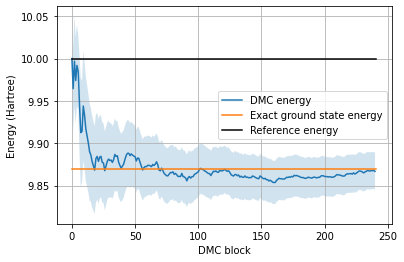

In [64]:
plt.figure()
ns = np.arange(0, len(dmc.energy_estimate))
plt.plot(ns, dmc.energy_estimate, label="DMC energy")
plt.fill_between(ns, 
    dmc.energy_estimate - dmc.energy_error, 
    dmc.energy_estimate + dmc.energy_error, alpha=0.2)

plt.plot([0, len(dmc.energy_estimate)], [exact, exact], label="Exact ground state energy")
plt.plot([0, len(dmc.energy_estimate)], [reference_energy, reference_energy], "black", label="Reference energy")
plt.legend()
plt.xlabel("DMC block")
plt.ylabel("Energy (Hartree)")
plt.grid()

In [65]:
flhf, flhf_warp, flpulay_exact, flpulay_exact_warp, flpulay_vd, flpulay_vd_warp, flpulay_exact_nocutoff, flpulay_exact_nocutoff_warp \
    = DMCForcesInput().compute_forces("dmc.pib.hdf5")

## Exact Force

In [66]:
plot_force_data_trace(flhf, flpulay_exact, flhf_warp, flpulay_exact_warp, bin_size=1)

NameError: name 'plot_force_data_trace' is not defined

In [ ]:
axes = plot_error_over_time(flhf, flpulay_exact, flhf_warp, flpulay_exact_nocutoff_warp, 20, 1)
for (ax, title) in zip(axes.T, ["Hellmann-Feynman force", "Pulay force", "Total force"]):
    ax[0].set_xlabel(r"$N_b$"); ax[1].set_xlabel(r"$N_b$")
    ax[0].set_ylabel("Force estimate"); ax[1].set_ylabel("Force error")
    ax[0].set_title(title)

## VD Force

In [ ]:
plot_force_data_trace(flhf, flpulay_vd, flhf_warp, flpulay_vd_warp)

In [ ]:
axes = plot_error_over_time(flhf, flpulay_vd, flhf_warp, flpulay_vd_warp, 20, 1)
for (ax, title) in zip(axes.T, ["Hellmann-Feynman force", "Pulay force", "Total force"]):
    ax[0].set_xlabel(r"$N_b$"); ax[1].set_xlabel(r"$N_b$")
    ax[0].set_ylabel("Force estimate"); ax[1].set_ylabel("Force error")
    ax[0].set_title(title)